# Check resolution with orthogonal dataset

### Notebook configuration

In [1]:
run_number          = 4734
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"

Zrange  =   50,  550
XYrange = -200,  200
Erange  =   30,   50
Znbins  =   10
XYnbins =   60
Enbins  =  200

split_fraction = 0.50

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 20

global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()


### Imports

In [2]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.io  .kdst_io        as kdstio

from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import gausstext

from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import fit_slices_3d_gauss

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
Ebins     = np.linspace(* Erange,  Enbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename   = os.path.expandvars(input_dst_filename)

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Read data

In [4]:
dst       = dstf.load_dst(input_dst_filename, "DST", "Events")
total_evt = len(dst)

train     = np.random.uniform(0, 1, size=total_evt) < split_fraction
train_dst = dst[ train]
test_dst  = dst[~train]

In [5]:
X  = train_dst.X   .values
Y  = train_dst.Y   .values
Z  = train_dst.Z   .values
T  = train_dst.time.values
T  = T - np.min(T)
E0 = train_dst.S2e .values

### Compute lifetime map

In [6]:
LT = fit_slices_2d_expo(X, Y, Z, E0, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)[1]
ok = LT.value < -100

LT_mean  = np.nanmean(LT.value      [ok])
LTu_mean = np.nanmean(LT.uncertainty[ok])

LT , LTu      = np.where(ok, -LT.value, -LT_mean), np.where(ok,  LT.uncertainty, -LTu_mean)
LT_correction = corrf.LifetimeXYCorrection(LT, LTu, XYcenters, XYcenters)
Ez            = E0 * LT_correction(Z, X, Y).value

### Compute geometry map

In [7]:
*_, Eave, Eaveu = fitf.profileXY(X, Y, Ez, XYnbins, XYnbins, XYrange, XYrange)
ok              = Eave > 1e3

E_mean  = np.mean(Eave [ok])
Eu_mean = np.mean(Eaveu[ok])


Eave, Eaveu    = np.where(ok, Eave, E_mean), np.where(ok, Eaveu, Eu_mean)
GEO_correction = corrf.Correction((XYcenters, XYcenters), Eave, Eaveu, norm_strategy = "index", norm_opts = {"index": (30, 30)})
Exyz           = Ez * GEO_correction(X, Y).value

### Compute time correction

In [8]:
t, e, eu     = fitf.profileX(T, Ez, 100)
T_correction = corrf.Correction((t,), e, eu, norm_strategy = "max")
Exyzt        = Exyz * T_correction(T).value

In [9]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1, 1, 1)
    sig_seed  = Npeak, Epeak, Speak

    seed = (*sig_seed, *bkg_seed)
    fit_range = (Epeak - 3 * Speak,
                 Epeak + 3 * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

def plot(data, signal=fitf.gauss, bkg=fitf.gauss):
    print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
    print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
    print("Chi2                  :", data.f.chi2)

    x = data.xy.x
    plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
    plt.plot        (x, data.f.fn   (x)               , lw=global_linewidth, color=global_linecolor   )
    plt.plot        (x, signal(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
    plt.fill_between(x, signal(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
    plt.plot        (x, bkg   (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
    plt.fill_between(x, bkg   (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
    plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
             max(data.xy.y) / 1.5,
             gausstext(data.f.values, data.f.errors, 41.5))
    plt.ylim(0)
    labels("E (keV)", "Entries")

### Corrections on the train data set

Resolution at 41.5 keV: 4.727 +- 0.010
Resolution at 2458 keV: 0.6142 +- 0.0013
Chi2                  : 4.82109780387


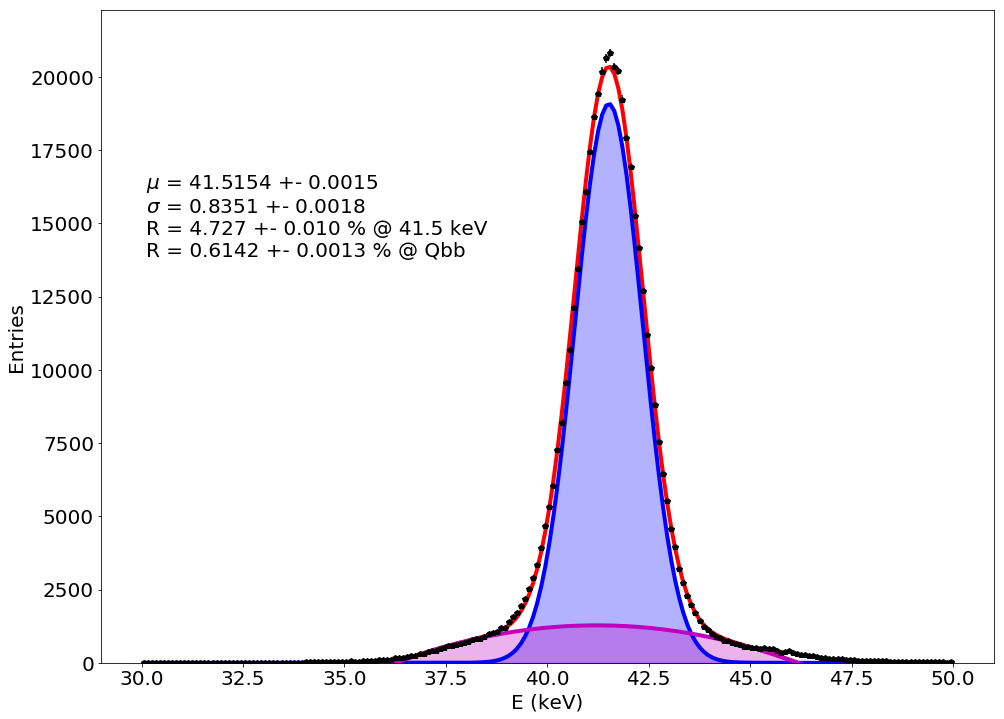

In [10]:
bkg  = fitf.polynom
data = measure_resolution(Exyzt * 41.5/np.mean(Exyzt), bkg=bkg)

plot(data, bkg=bkg)

In [11]:
Xt = test_dst.X.values
Yt = test_dst.Y.values
Zt = test_dst.Z.values
Tt = test_dst.time.values
Tt = Tt - Tt.min()
Et = test_dst.S2e.values

Resolution at 41.5 keV: 4.785 +- 0.010
Resolution at 2458 keV: 0.6217 +- 0.0013
Chi2                  : 4.21566446641


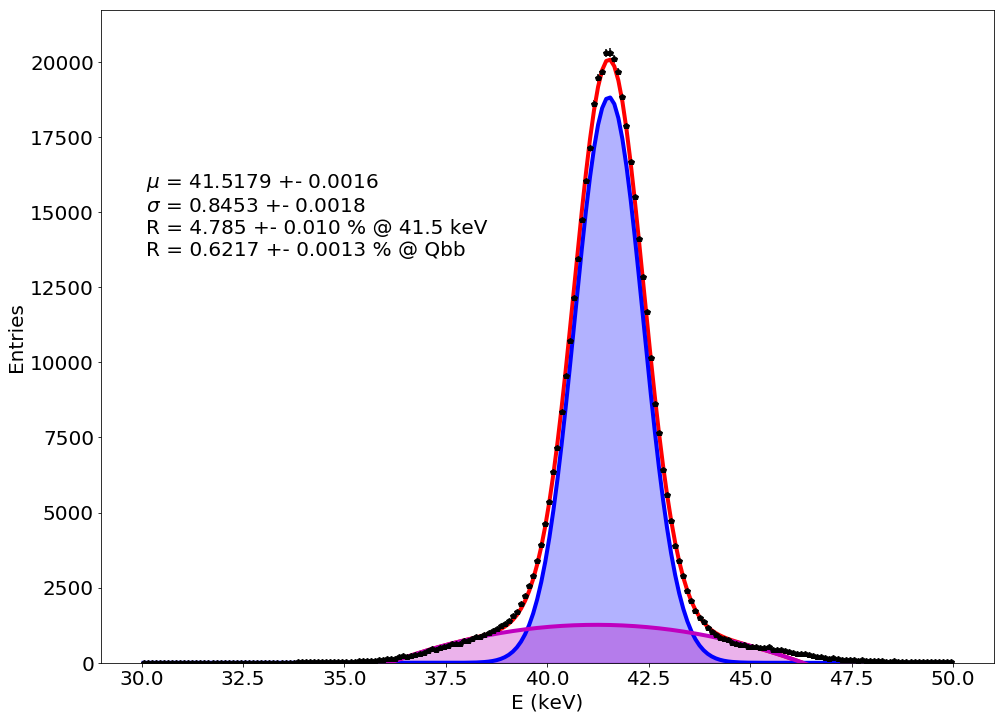

In [12]:
Et    = Et *  LT_correction(Zt, Xt, Yt).value
Et    = Et * GEO_correction(Xt, Yt).value
Et    = Et *   T_correction(Tt).value
Et    = Et * 41.5/np.mean(Et)

bkg  = fitf.polynom
data = measure_resolution(Et, bkg=bkg)


mean_energy  = data.f.values[1]
mean_energyu = data.f.errors[1]
plot(data, bkg=bkg)

In [27]:
xybins    = np.linspace(*XYrange, 21)
xycenters = shift_to_bin_centers(xybins)
zbins     = np.linspace(* Zrange, 21)
zcenters  = shift_to_bin_centers(zbins)
mean, sigma, chi2, ok = fit_slices_3d_gauss(Xt, Yt, Zt, Et, xybins, xybins, zbins, Ebins, 30, do_fit=False)
zmatrix   = np.array([[zcenters for y in xycenters] for x in xycenters])
rmatrix   = np.array([[[(x**2 + y**2)**0.5 for z in zcenters] for y in xycenters] for x in xycenters])

In [28]:
deviation  = 100 * (mean.value / mean_energy - 1)
deviationu = ((mean.uncertainty / mean.value)**2 +
              (mean_energyu     / mean_energy**2))**0.5 * deviation
pull       = (mean.value - mean_energy) / (mean.uncertainty**2 + mean_energyu**2)**0.5
reso       = 2.35 * sigma.value / mean.value
resou      = reso * (sigma.uncertainty**2/sigma.value**2 + mean.uncertainty**2 / mean.value**2)**0.5

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


### Resolution

41.4823799865
0.197761370828


6177

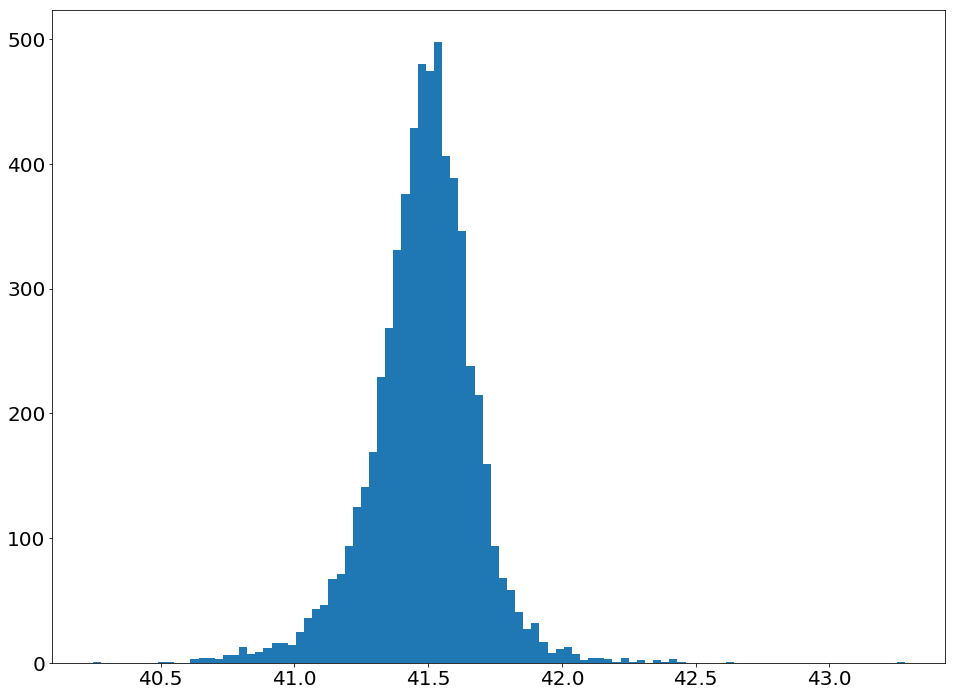

In [29]:
plt.hist(mean.value[mean.value > 0], 100);
print(np.mean(mean.value[mean.value > 0]))
print(np.std (mean.value[mean.value > 0]))
np.count_nonzero(mean.value)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


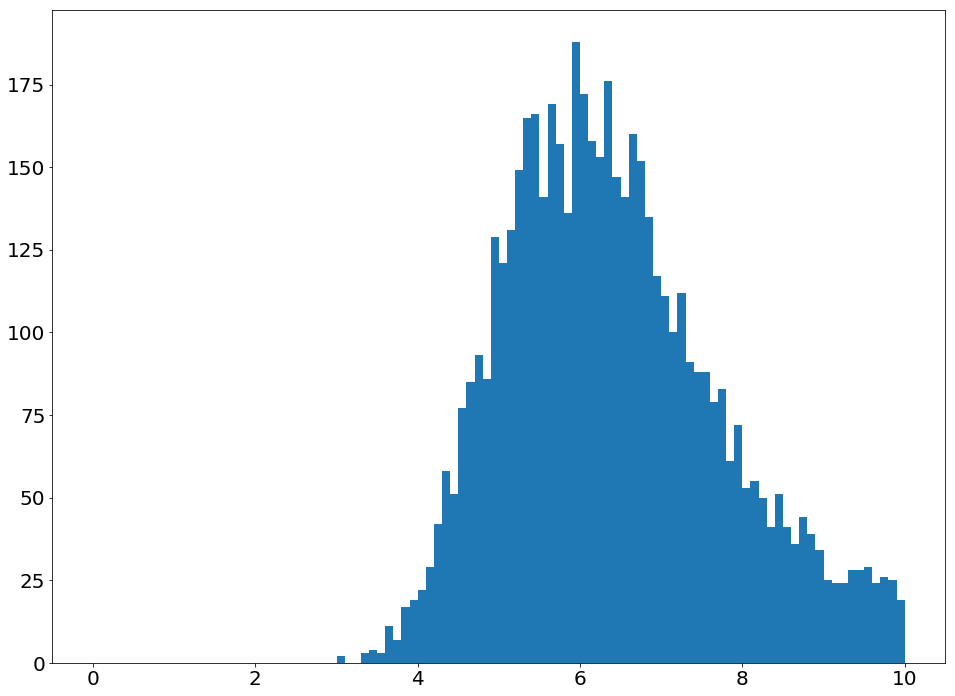

In [36]:
plt.hist(reso[reso > 0] * 100, 100, (0, 10));

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


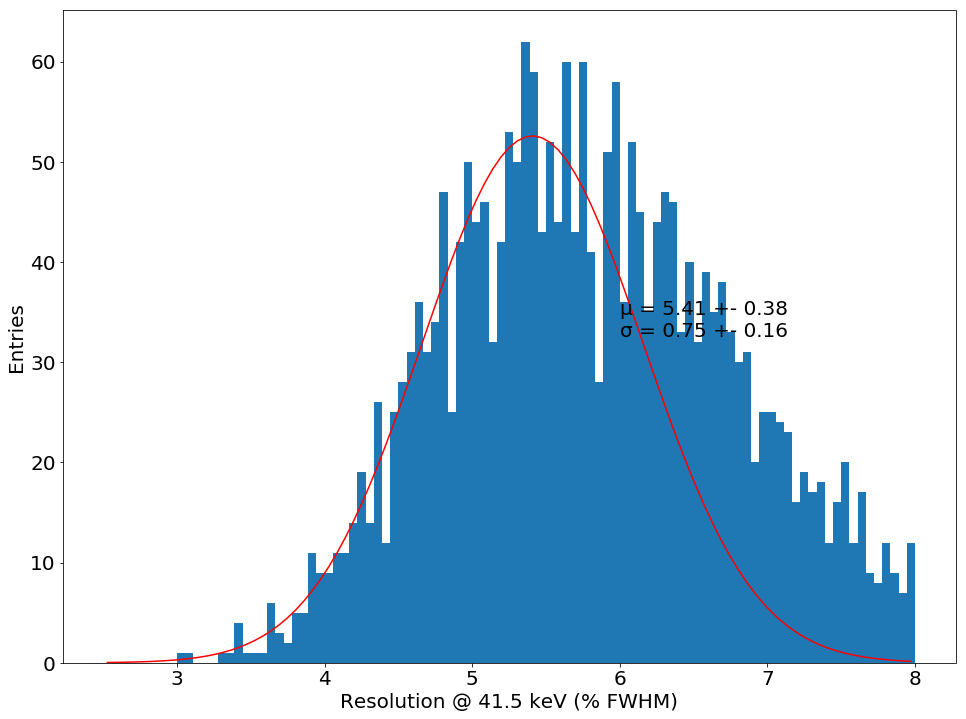

In [37]:
y, x, _   = hist(reso[(reso > 0) & (rmatrix < 130)] * 100, np.linspace(2.5, 8, 100))

f = fitf.fit(fitf.gauss, x, y, (1, 0, 1), fit_range=(3,5))
plt.plot(x, f.fn(x), "r-")

_, mu, sig = map(measurement_string, f.values, f.errors)
plt.text(6, plt.ylim()[1]/2, f"µ = {mu}\nσ = {sig}")
labels("Resolution @ 41.5 keV (% FWHM)", "Entries")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


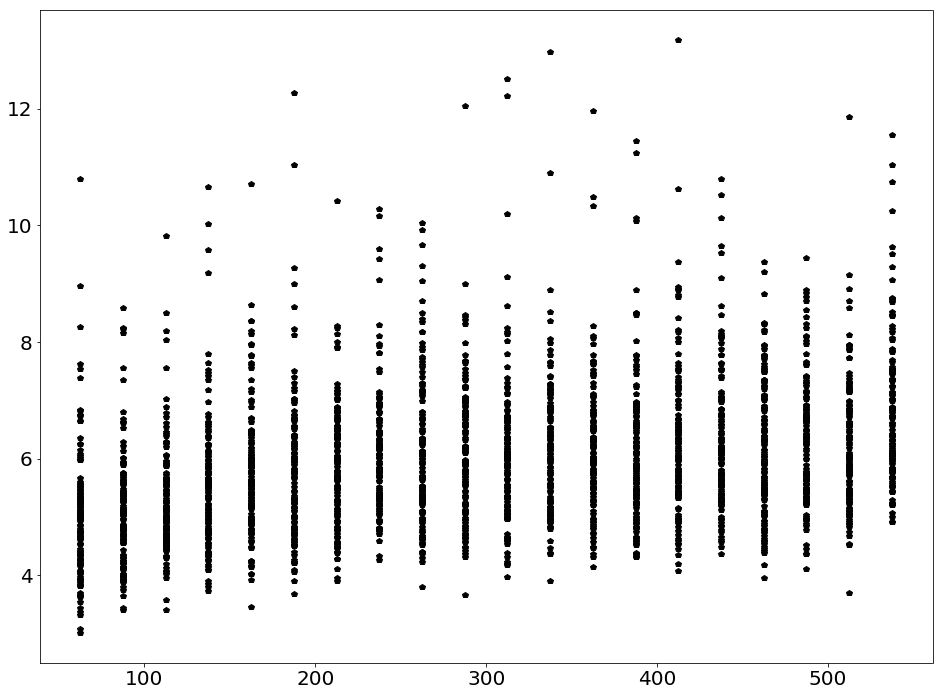

In [38]:
ok = (reso > 0) & (resou > 0) & (rmatrix < 130)
plt.errorbar(zmatrix[ok], 100*reso[ok], resou[ok], fmt="kp");

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


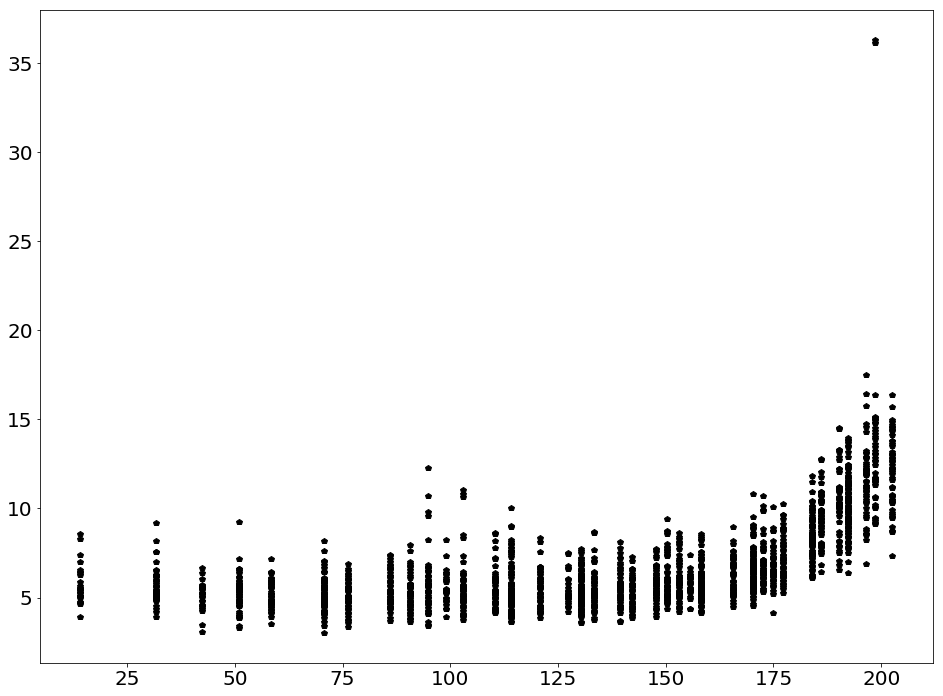

In [40]:
ok = (reso > 0) & (resou > 0) & (zmatrix < 200)
plt.errorbar(rmatrix[ok], 100*reso[ok], resou[ok], fmt="kp");

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


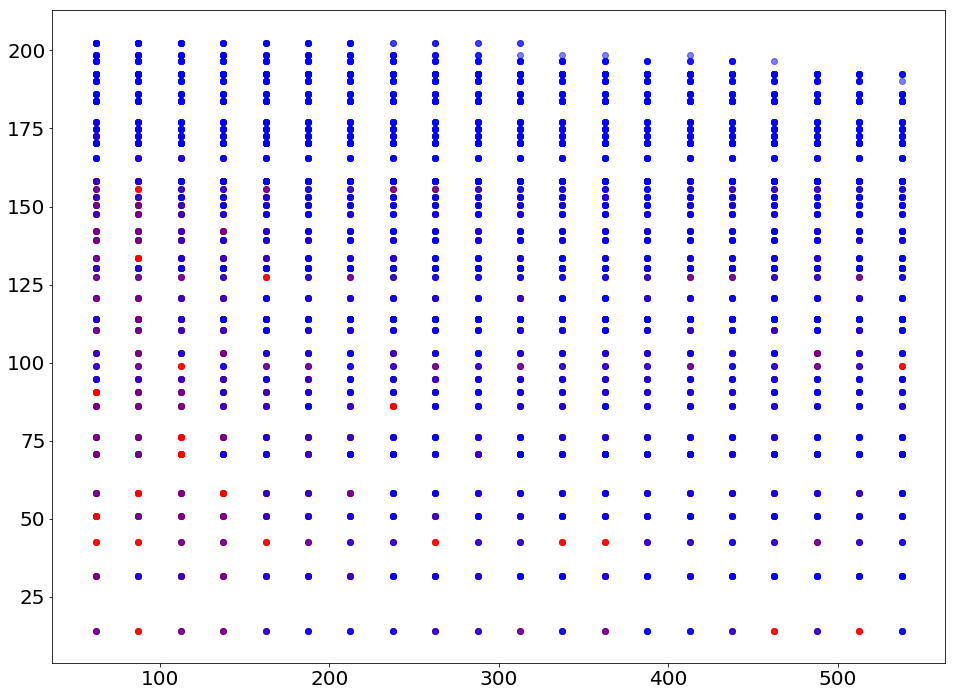

In [42]:
ok = (reso > 0) & (reso < 0.06)
plt.scatter(zmatrix[ok], rmatrix[ok], c="r", alpha=0.5)

ok = (reso > 0.06)
plt.scatter(zmatrix[ok], rmatrix[ok], c="b", alpha=0.5)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


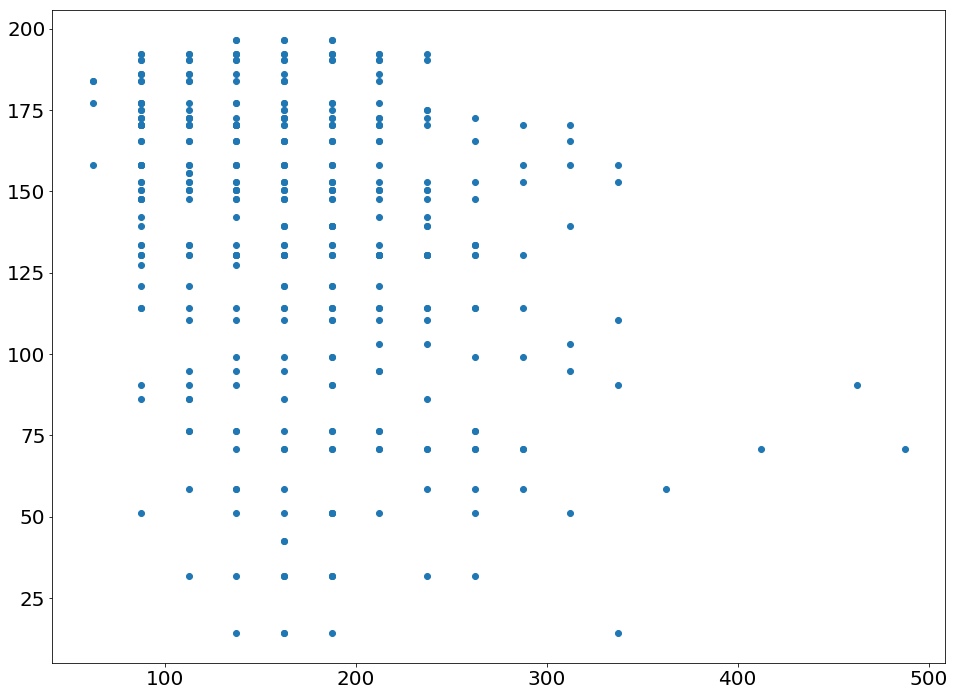

In [84]:
ok = (reso > 0.04)
plt.scatter(zmatrix[ok], rmatrix[ok]);

### Deviation

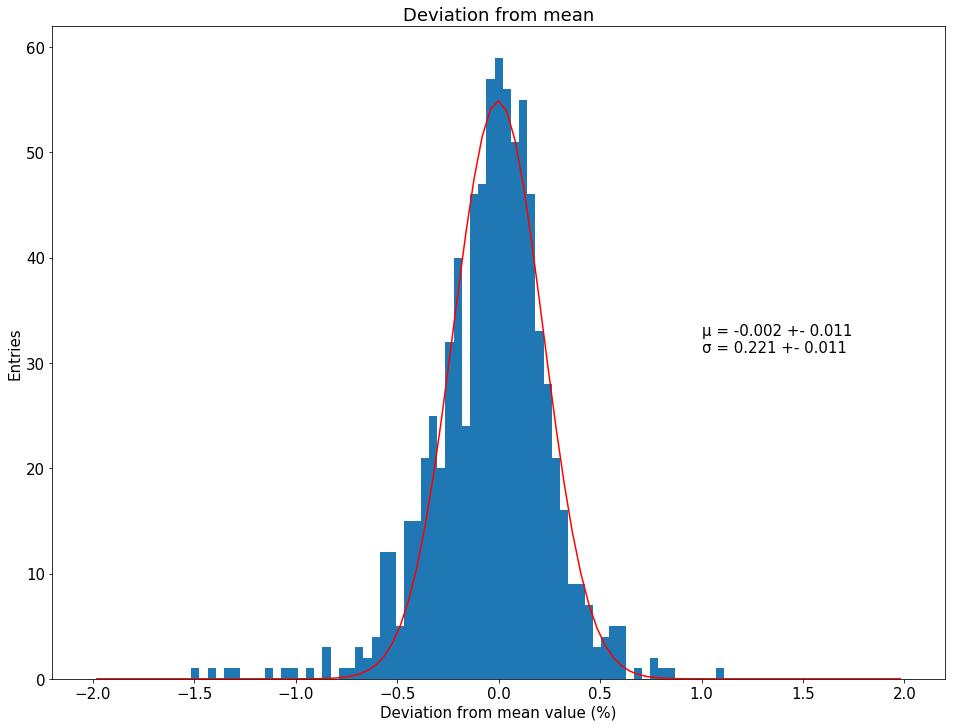

In [22]:
y, x, _   = hist(deviation.flatten(), np.linspace(-2, 2, 100))

f = fitf.fit(fitf.gauss, x, y, (1, 0, 1), fit_range=(-.5, .5))
plt.plot(x, f.fn(x), "r-")

_, mu, sig = map(measurement_string, f.values, f.errors)
plt.text(1, plt.ylim()[1]/2, f"µ = {mu}\nσ = {sig}")
labels("Deviation from mean value (%)", "Entries", "Deviation from mean")

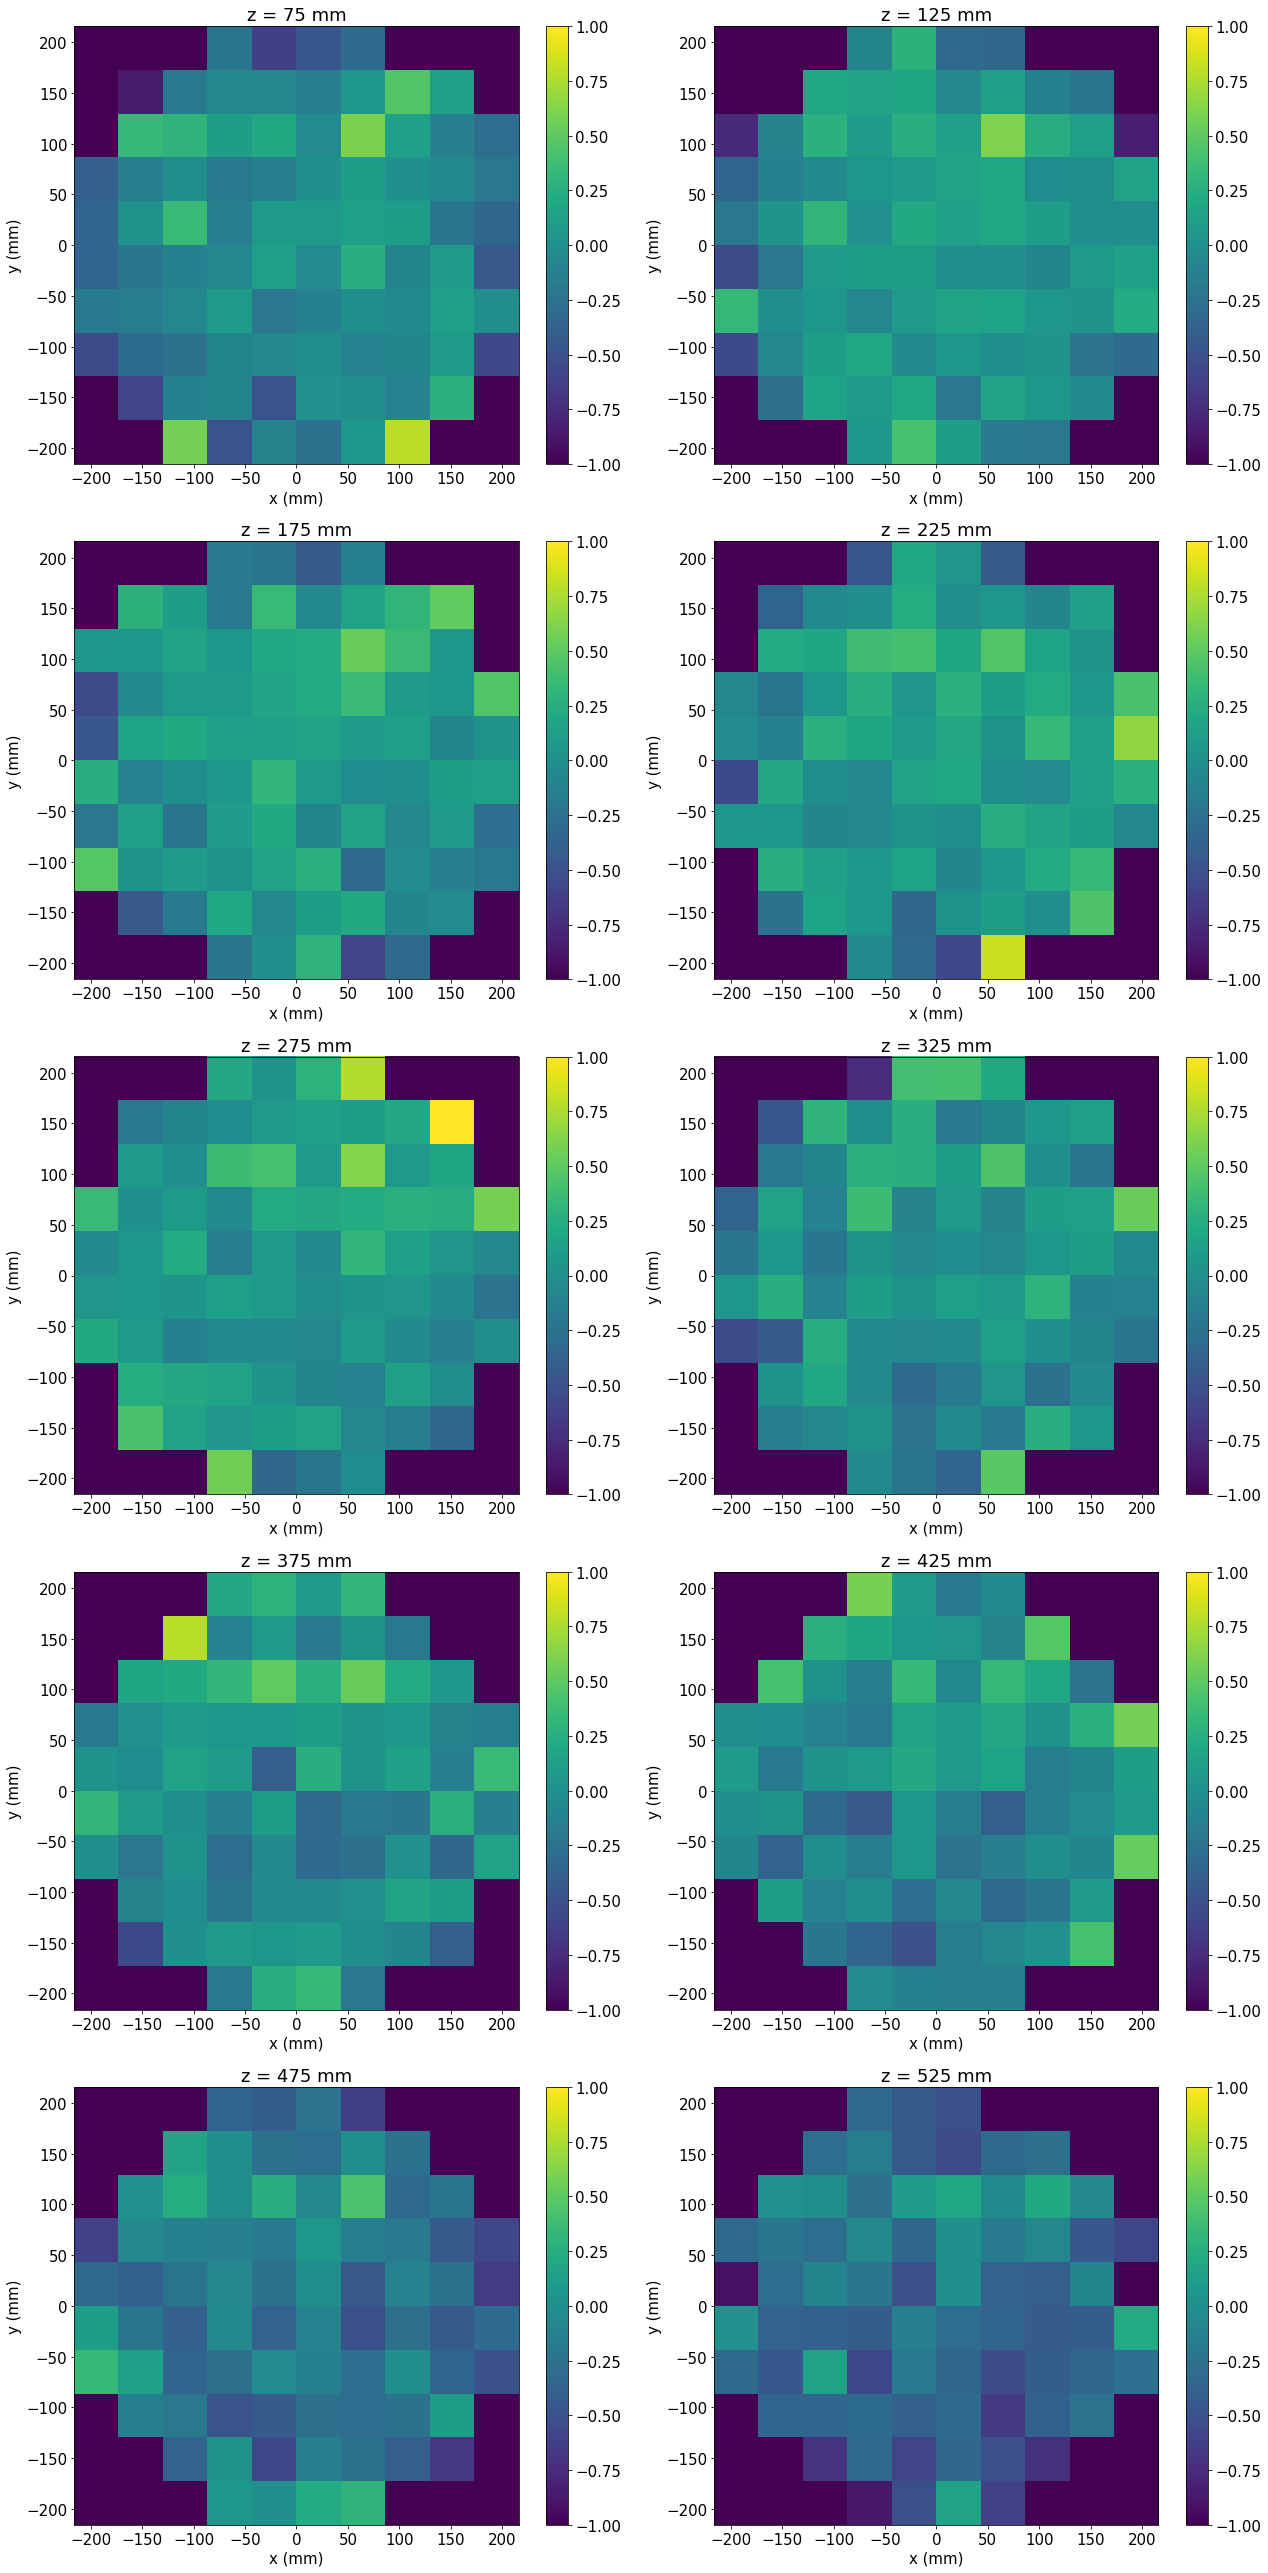

In [23]:
plt.figure(figsize=(18, 36))
for k, z in enumerate(zcenters):
    plt.subplot(5, 2, k+1)
    *_, cb = display_matrix(xycenters, xycenters, deviation[:, :, k],
                            vmin = -1,
                            vmax = +1,
                            new_figure=False)
    labels("x (mm)", "y (mm)", f"z = {z:.0f} mm")
plt.tight_layout()

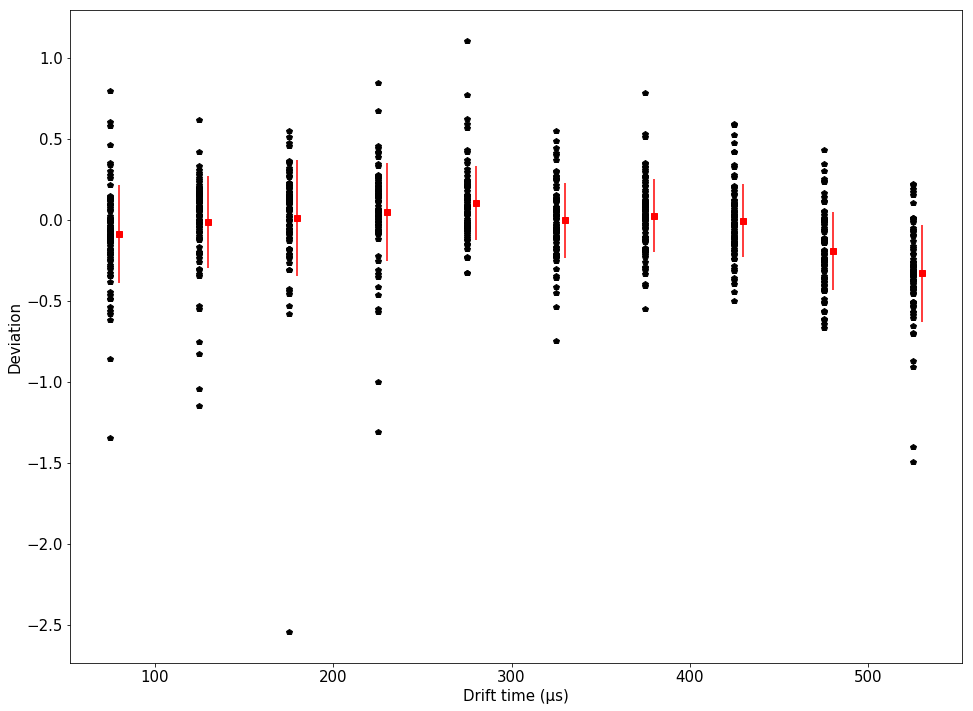

In [33]:
zcenters_repeated = np.array([[zcenters for x in xycenters] for y in xycenters])
isok = deviation > -10
plt.errorbar(zcenters_repeated[isok], deviation[isok], deviationu[isok], fmt="kp")

d = np.where(isok, deviation, np.nan)
av  = np.nanmean(d, axis=(0,1))
avu = np.nanstd (d, axis=(0,1))
plt.errorbar(zcenters + 5, av, avu, fmt="sr")
labels("Drift time (µs)", "Deviation")

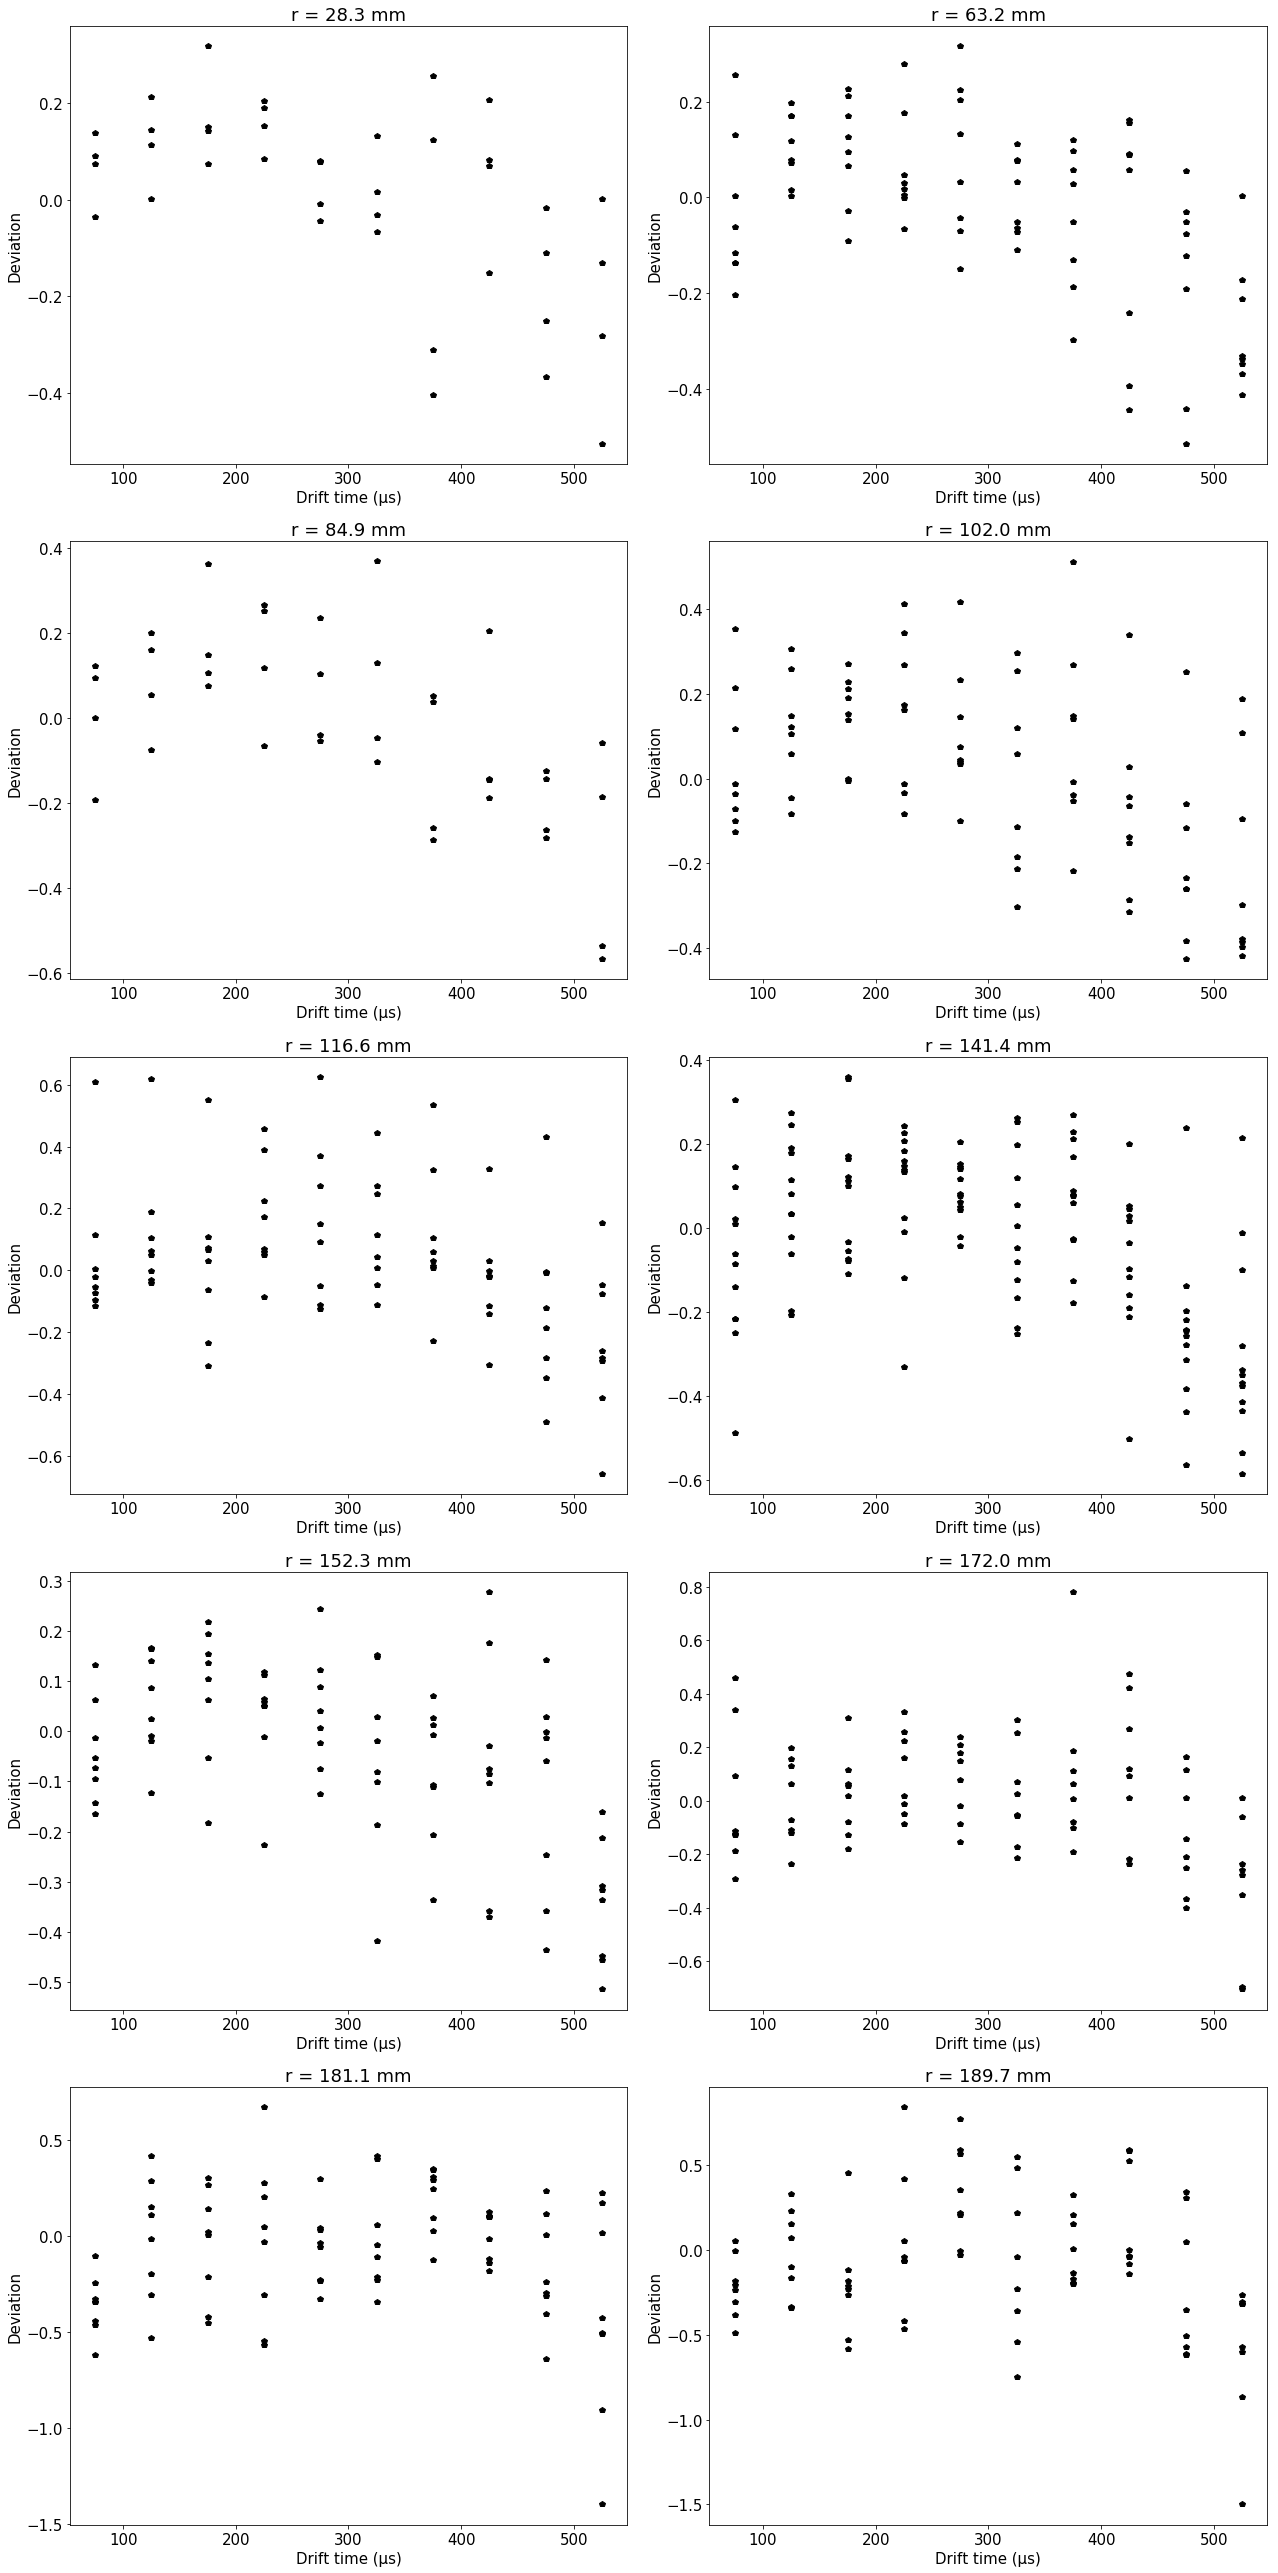

In [36]:
plt.figure(figsize=(18, 36))
rvalues  = np.array([[np.sqrt(x**2 + y**2) for y in xycenters] for x in xycenters])
rcenters = np.unique(r)[:-4]
for i, x in enumerate(xycenters):
    for j, y in enumerate(xycenters):
        r_ = r[i, j]
        if r_ not in rcenters: continue
        index = np.argwhere(rcenters == r_)[0, 0]

        isok  = ok[i, j]
        plt.subplot(5, 2, index + 1)
        plt.errorbar(zcenters[isok], deviation[i, j, isok], deviationu[i, j, isok], fmt="kp")
        labels("Drift time (µs)", "Deviation", f"r = {r_:.1f} mm")
plt.tight_layout()

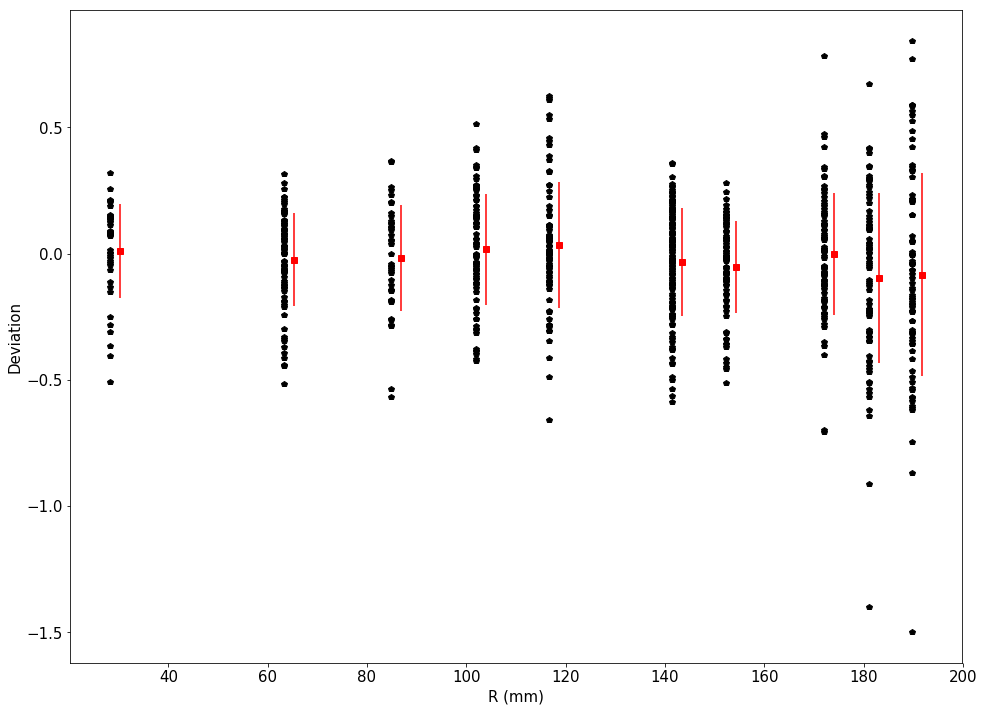

In [43]:
rvalues  = np.array([[[np.sqrt(x**2 + y**2)for z in zcenters] for y in xycenters] for x in xycenters])
rcenters = np.unique(r)[:-4]

aves  = np.zeros_like(rcenters)
aveus = np.zeros_like(rcenters)
for i, r_ in enumerate(rcenters):
    where = (rvalues == r_) & (deviation > -10)
    d     = deviation [where]
    du    = deviationu[where]
    plt.errorbar(np.full(len(d), r_), d, du, fmt="kp")
    aves [i] = np.mean(d)
    aveus[i] = np.std (d)
    
plt.errorbar(rcenters + 2, aves, aveus, fmt="rs")
labels("R (mm)", "Deviation")

### Pull

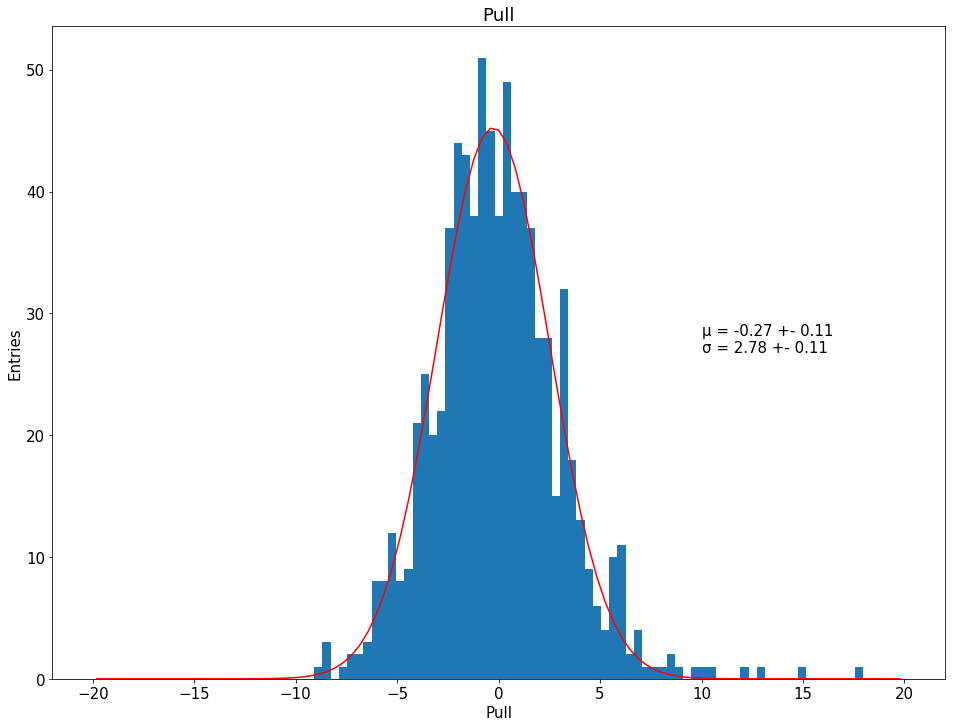

In [48]:
y, x, _ = hist(pull.flatten(), np.linspace(-20, 20, 100))

f = fitf.fit(fitf.gauss, x, y, (1, 0, 1), fit_range=(-8, 8))
plt.plot(x, f.fn(x), "r-")

_, mu, sig = map(measurement_string, f.values, f.errors)
plt.text(10, plt.ylim()[1]/2, f"µ = {mu}\nσ = {sig}")
labels("Pull", "Entries", "Pull")

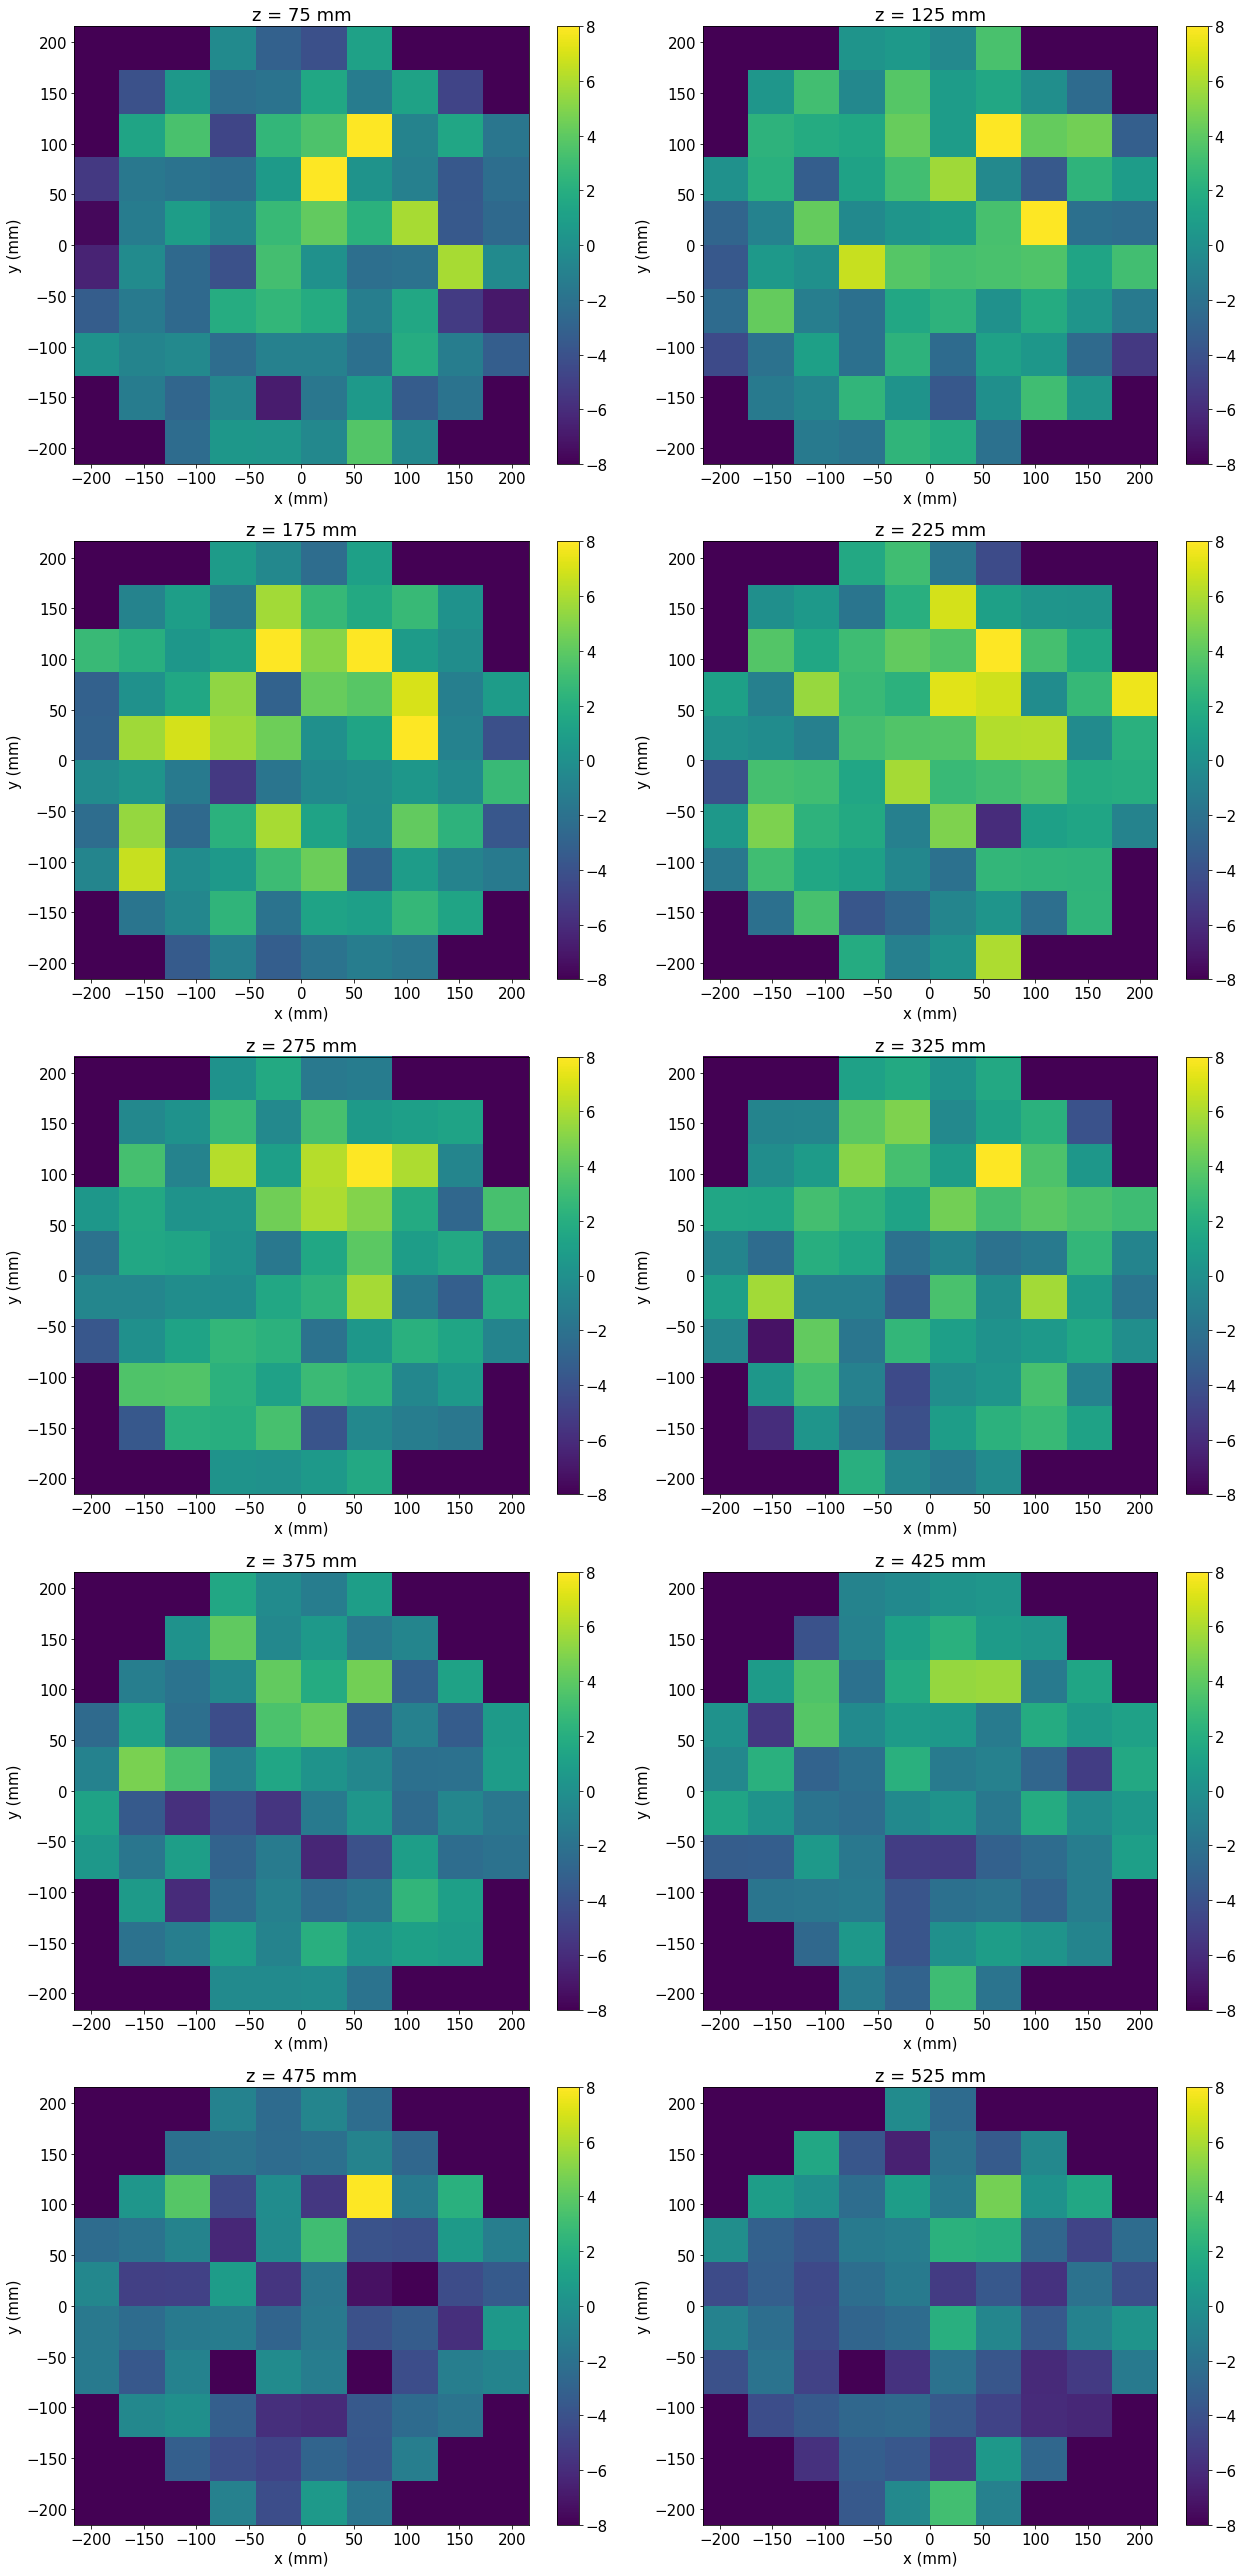

In [49]:
plt.figure(figsize=(18, 36))
for k, z in enumerate(zcenters):
    plt.subplot(5, 2, k+1)
    *_, cb = display_matrix(xycenters, xycenters, pull[:, :, k],
                            vmin = -8,
                            vmax = +8,
                            new_figure=False)
    labels("x (mm)", "y (mm)", f"z = {z:.0f} mm")
plt.tight_layout()

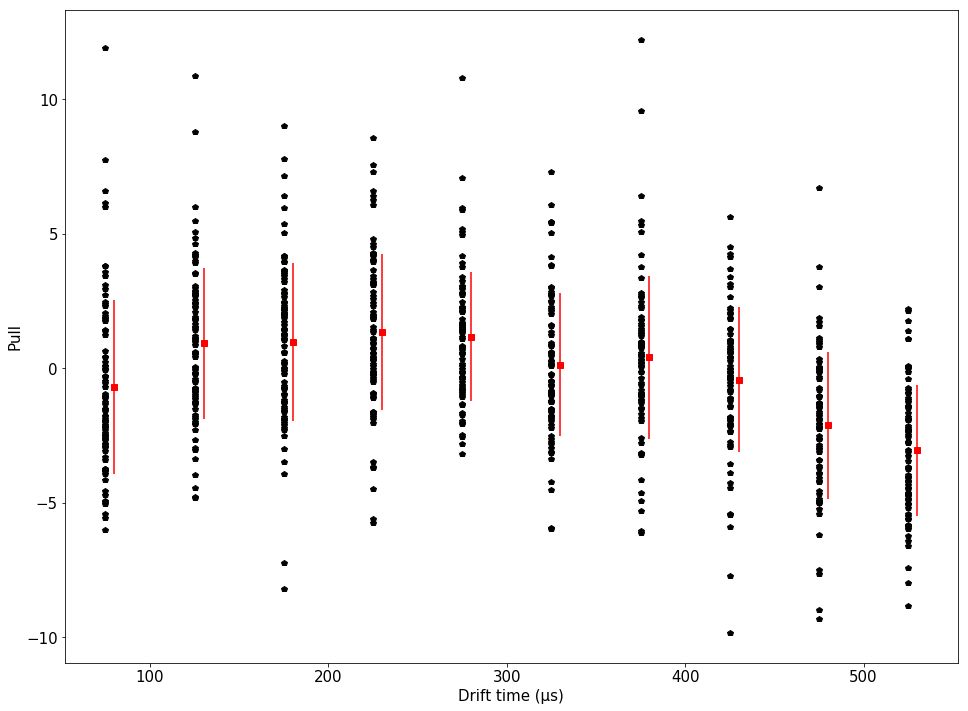

In [44]:
zcenters_repeated = np.array([[zcenters for x in xycenters] for y in xycenters])
isok = pull > -10
plt.errorbar(zcenters_repeated[isok], pull[isok], fmt="kp")

d = np.where(isok, pull, np.nan)
av  = np.nanmean(d, axis=(0,1))
avu = np.nanstd (d, axis=(0,1))
plt.errorbar(zcenters + 5, av, avu, fmt="sr")
labels("Drift time (µs)", "Pull")

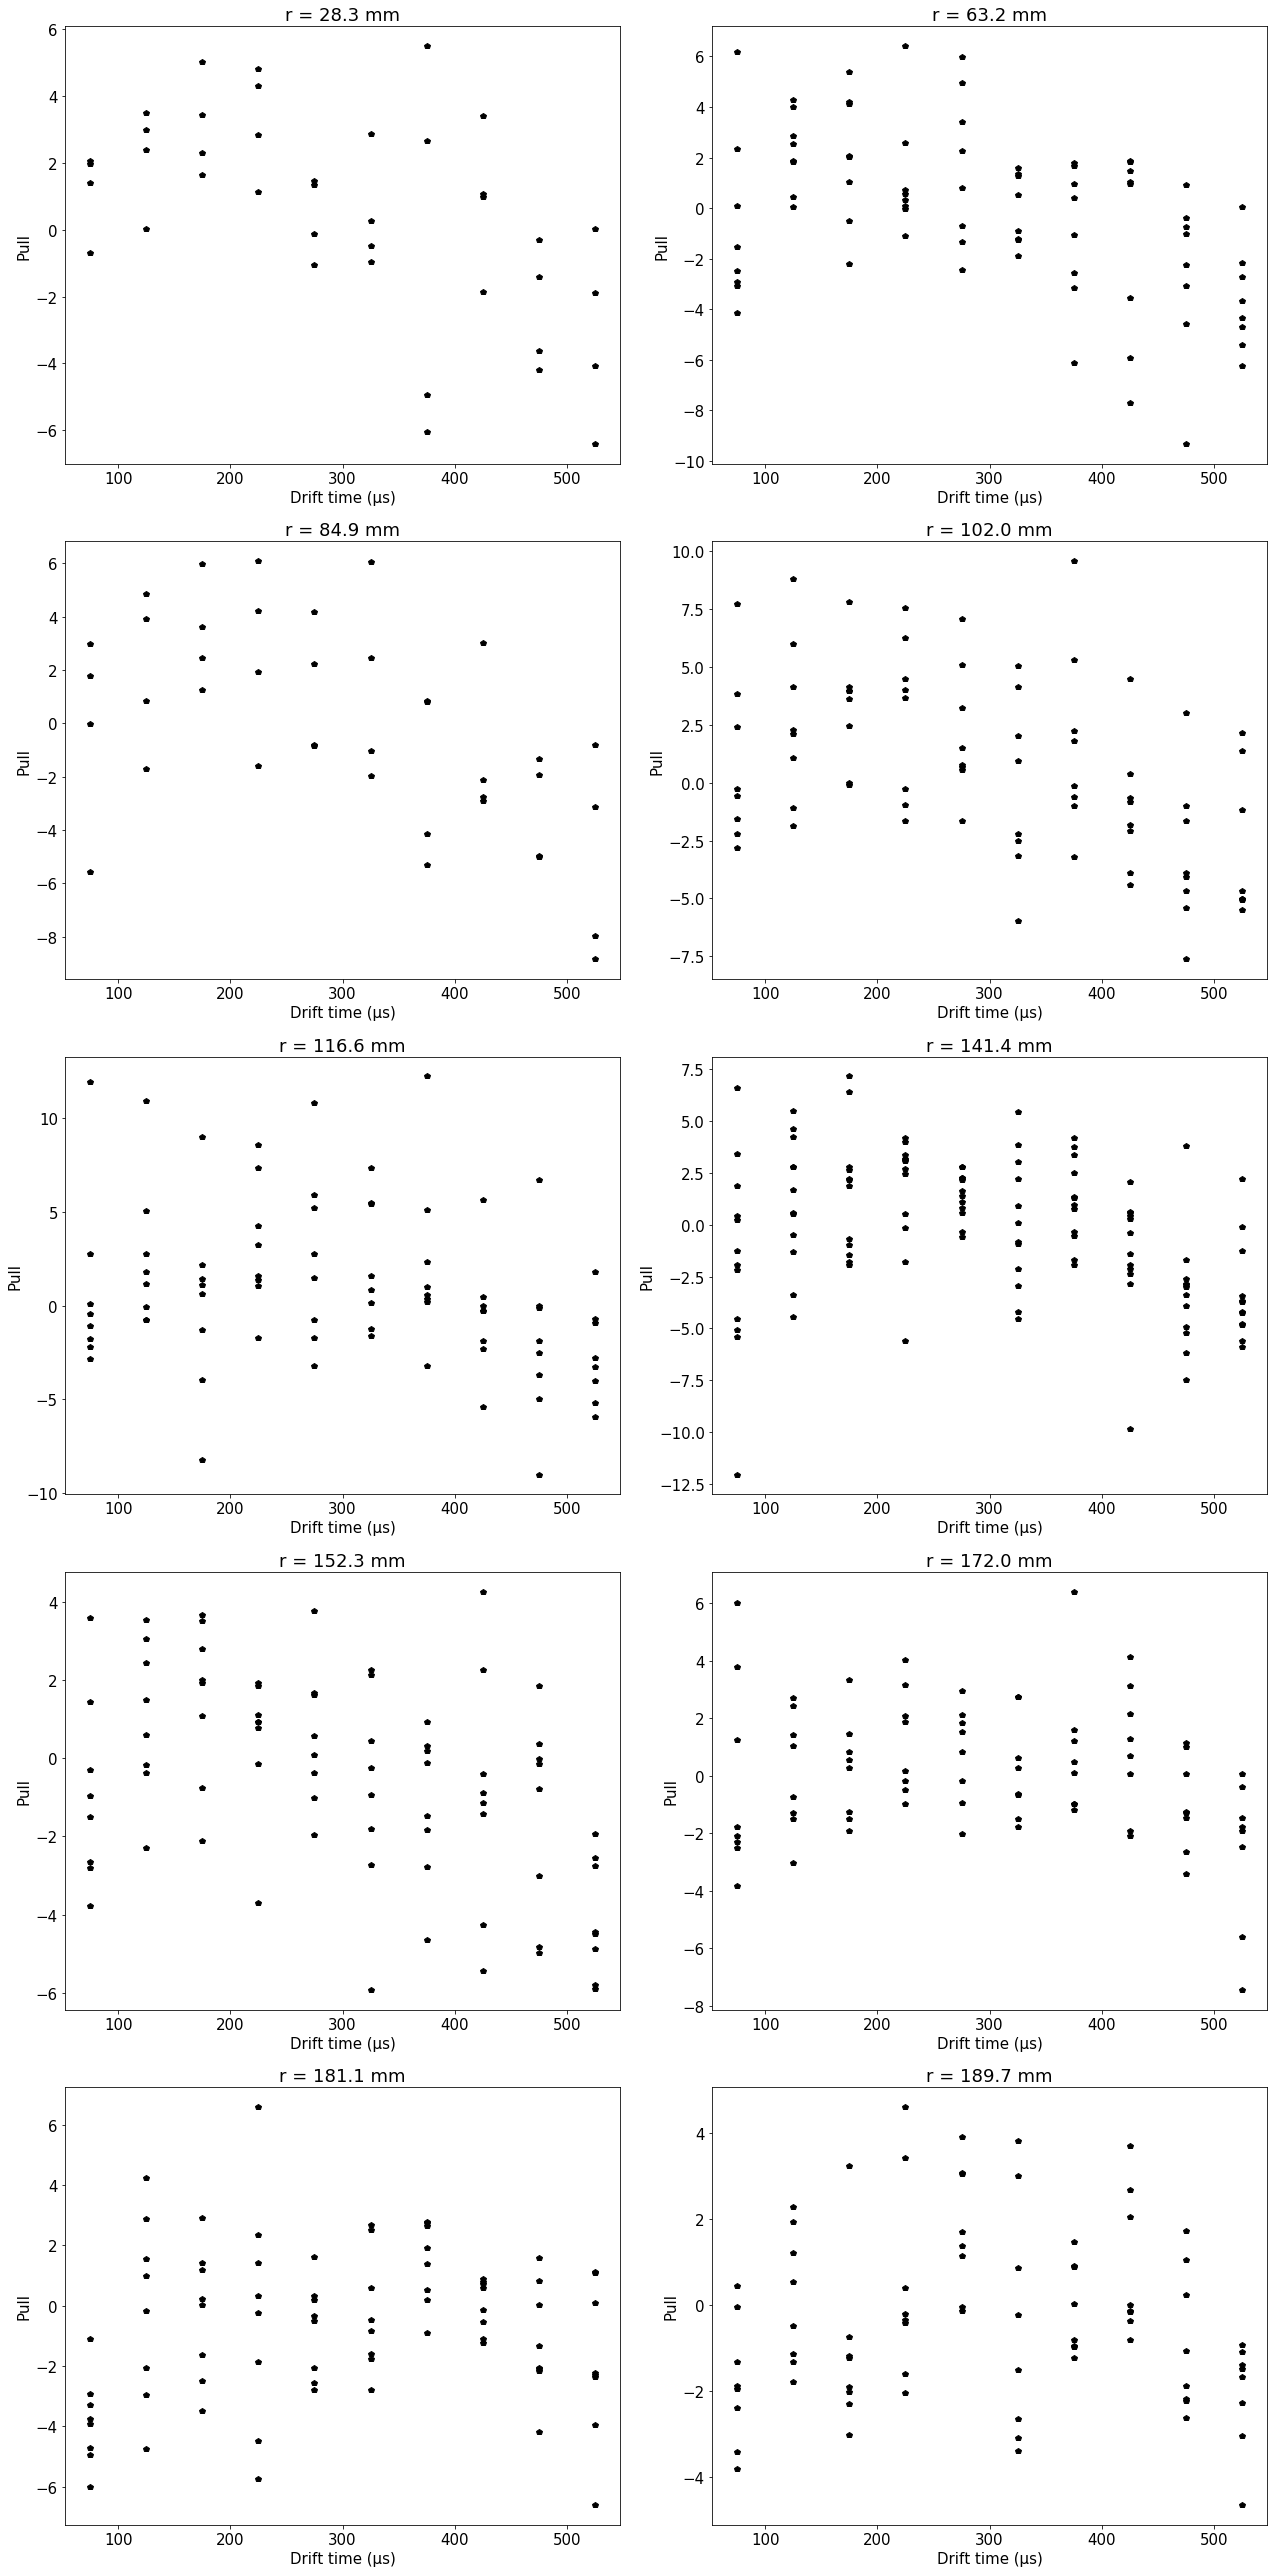

In [45]:
plt.figure(figsize=(18, 36))
rvalues  = np.array([[np.sqrt(x**2 + y**2) for y in xycenters] for x in xycenters])
rcenters = np.unique(r)[:-4]
for i, x in enumerate(xycenters):
    for j, y in enumerate(xycenters):
        r_ = r[i, j]
        if r_ not in rcenters: continue
        index = np.argwhere(rcenters == r_)[0, 0]

        isok  = ok[i, j]
        plt.subplot(5, 2, index + 1)
        plt.errorbar(zcenters[isok], pull[i, j, isok], fmt="kp")
        labels("Drift time (µs)", "Pull", f"r = {r_:.1f} mm")
plt.tight_layout()

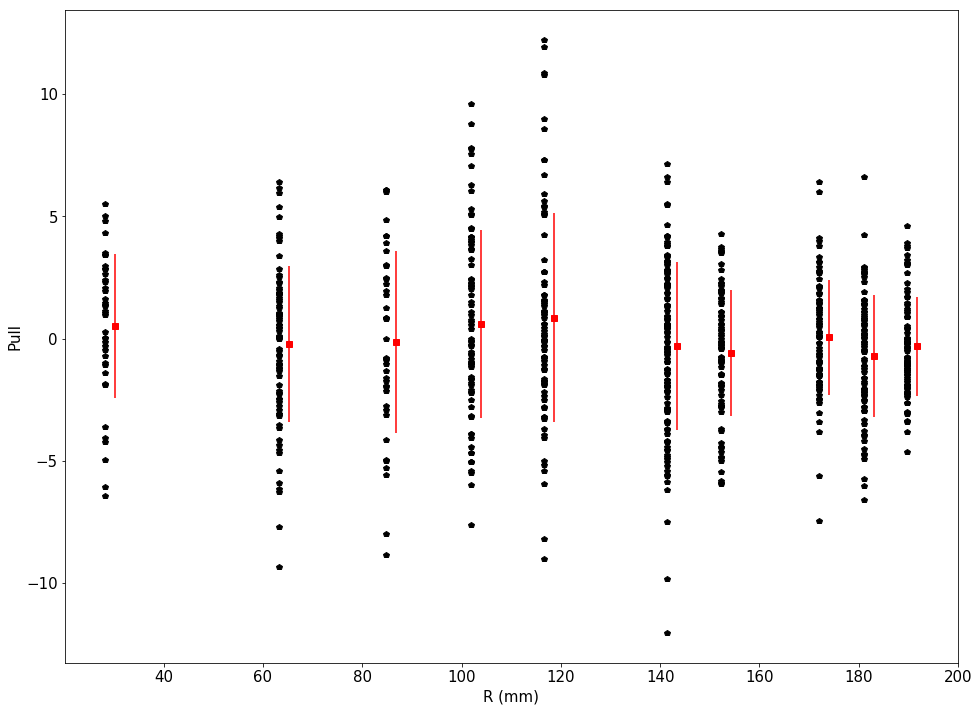

In [46]:
rvalues  = np.array([[[np.sqrt(x**2 + y**2)for z in zcenters] for y in xycenters] for x in xycenters])
rcenters = np.unique(r)[:-4]

aves  = np.zeros_like(rcenters)
aveus = np.zeros_like(rcenters)
for i, r_ in enumerate(rcenters):
    where = (rvalues == r_) & (deviation > -10)
    d     = pull [where]
    plt.errorbar(np.full(len(d), r_), d, fmt="kp")
    aves [i] = np.mean(d)
    aveus[i] = np.std (d)
    
plt.errorbar(rcenters + 2, aves, aveus, fmt="rs")
labels("R (mm)", "Pull")